# Calculating and saving parameters

In [1]:
import os 
import json 
import numpy as np
import matplotlib.pyplot as plt

from Parameters import *
from Geometry import *
from Straight_Method import solvesystem as straight_solvesystem
from Fast_Method import solvesystem as fast_solvesystem

Solvers = {
    'Straight': straight_solvesystem,
    'Fast': fast_solvesystem
}

def save(filename, Params):
    solver = Solvers[Params['Solver_type']]
    packing = Packings[Params['Packing']]

    rings_4d = packing(Params)
    phi_0z_4d = {
        orientation: list(np.ones(Params['Numbers'][orientation]
                             ) * (orientation == 'z'
                                  )) for orientation in Params['Orientations']
        }
    print('Количество колец:', Params['Numbers'])
    Data = solver(Params, rings_4d, phi_0z_4d)

    name = f'{Params["Packing"]}_NoGrad_{Params["shape"]}_{Params["Orientations"]}_{Params["Solver_type"]}'
    os.makedirs(f'./{filename}/{name}', exist_ok=True)

    # Saving modeling parameters in readable format
    with open(f'./{filename}/{name}/Params.json', 'w') as f:
        json.dump(Params, f)

    # Save full calculated data in npz format
    calc_data = {
        'Currents': Data['Currents'],
        'Omega': Data['Omega'],
        'Polarization': Data['Polarization'],
        'Phi_0z': Data['Phi_0z'],
    }
    np.savez(f'./{filename}/{name}/Currents.npz', **calc_data)
    
    # Save neccesary data for plotting in npz format
    pol_data = {
        'Polarization': Data['Polarization'],
        'Omega': Data['Omega'],
        'Phi_0z': Data['Phi_0z'],
    }
    np.savez(f'./{filename}/{name}/Polarization.npz', **pol_data)

def open_model(filename, Params, Currents = 'False', Polarization = 'True'):
    name = f'{Params["Packing"]}_NoGrad_{Params["shape"]}_{Params["Orientations"]}_{Params["Solver_type"]}'
    data = {}
    with open(f'./{filename}/{name}/Params.json', 'r') as f:
        data['Params'] = json.load(f)
    
    if Currents == 'True':
        with np.load(f'./{filename}/{name}/Currents.npz') as f:
            data['Currents'] = f['Currents']
            data['Omega'] = f['Omega']
            data['Polarization'] = f['Polarization']
            data['Phi_0z'] = f['Phi_0z']
    elif Polarization == 'True':
        with np.load(f'./{filename}/{name}/Polarization.npz') as f:
            data['Polarization'] = f['Polarization']
            data['Omega'] = f['Omega']
            data['Phi_0z'] = f['Phi_0z']
    return data

In [7]:

Params['Solver_type'] = 'Fast'
Params['Threads'] = 1

for n in range(100, 101):
    Params['N'], Params['shape'] = to3D(n, 1, 1, 'zyx')
    save('DATA', Params)

Количество колец: {'z': 101, 'y': 200, 'x': 200}
Cirvecs forming


100%|██████████| 3/3 [00:00<00:00, 58.53it/s]


Circvecs: Done
FFT solving


100%|██████████| 1000/1000 [01:33<00:00, 10.75it/s]

FFT solving: Done, shape = [('z', (101, 1, 1)), ('y', (100, 2, 1)), ('x', (100, 1, 2))]


In [4]:
Params['N'], Params['shape'] = to3D(10, 10, 10, 'zyx')
Params['Solver_type'] = 'Straight'

In [ ]:
save('DATA', Params)

# Plotting graphs for chi

### Chi for different structures


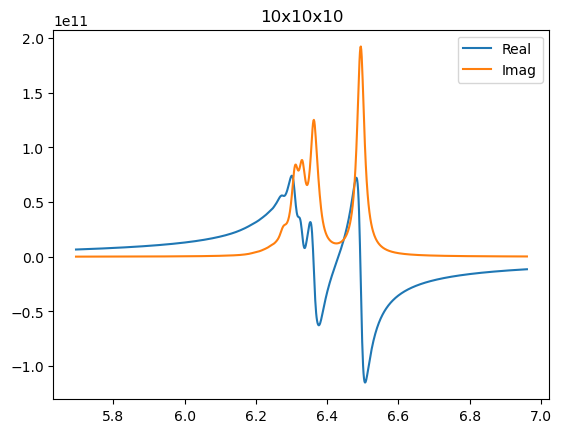

In [13]:
Params['N'], Params['shape'] = to3D(10, 10, 10, 'zyx')

Params['Solver_type'] = 'Fast'
data = open_model('DATA', Params)
plt.title(Params['shape'])
plt.plot(data['Omega']/2/np.pi/1e6, data['Polarization'][:, 0].real, label='Real')
plt.plot(data['Omega']/2/np.pi/1e6, data['Polarization'][:, 0].imag, label='Imag')
plt.legend()

Params['Solver_type'] = 'Straight'
data = open_model('DATA', Params)
#plt.plot(data['Omega']/2/np.pi/1e6, data['Polarization'][:, 0].real, label='Real')
#plt.plot(data['Omega']/2/np.pi/1e6, data['Polarization'][:, 0].imag, label='Imag')
plt.legend()


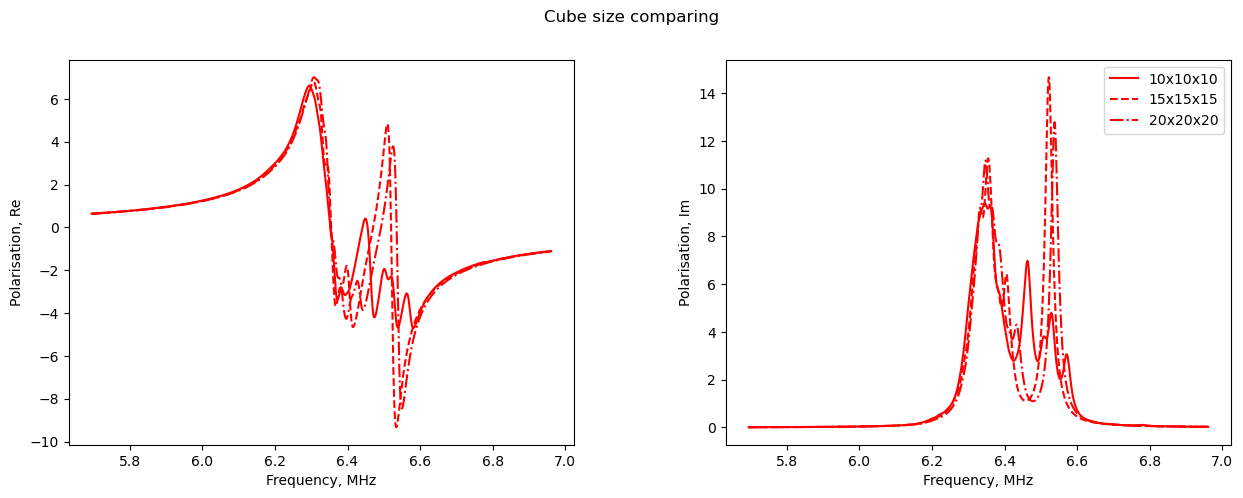

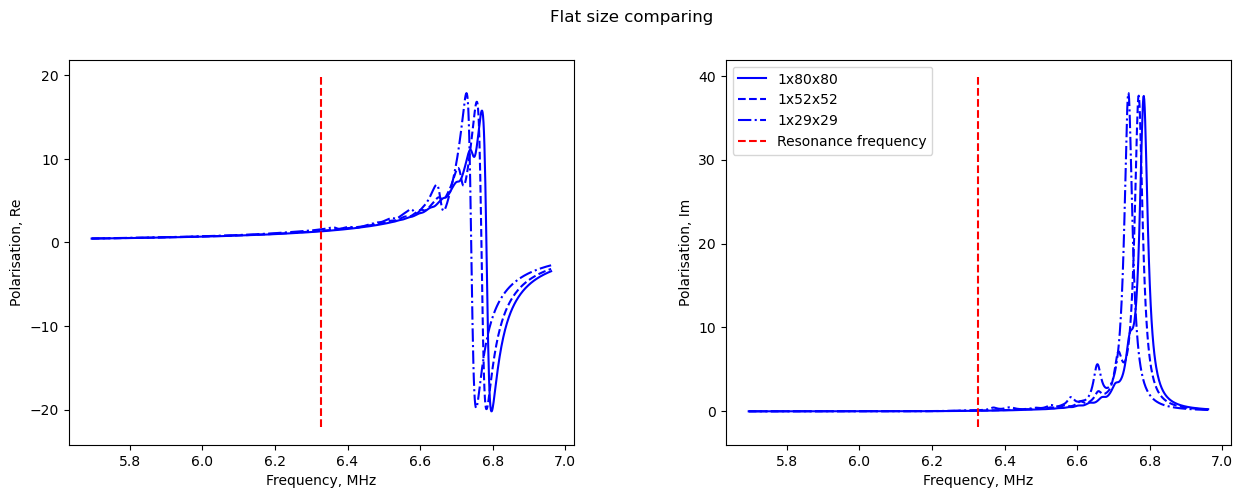

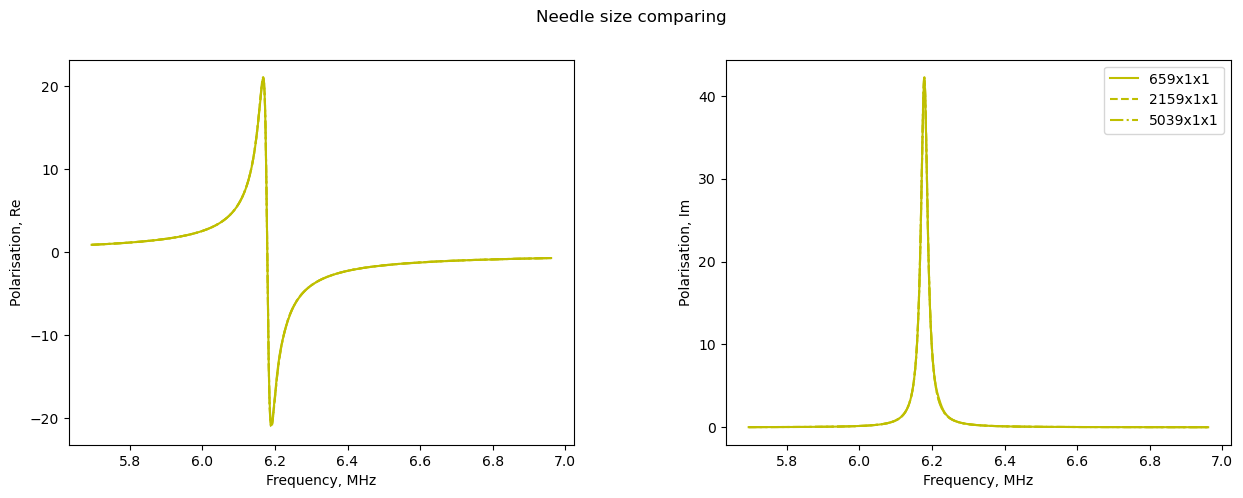

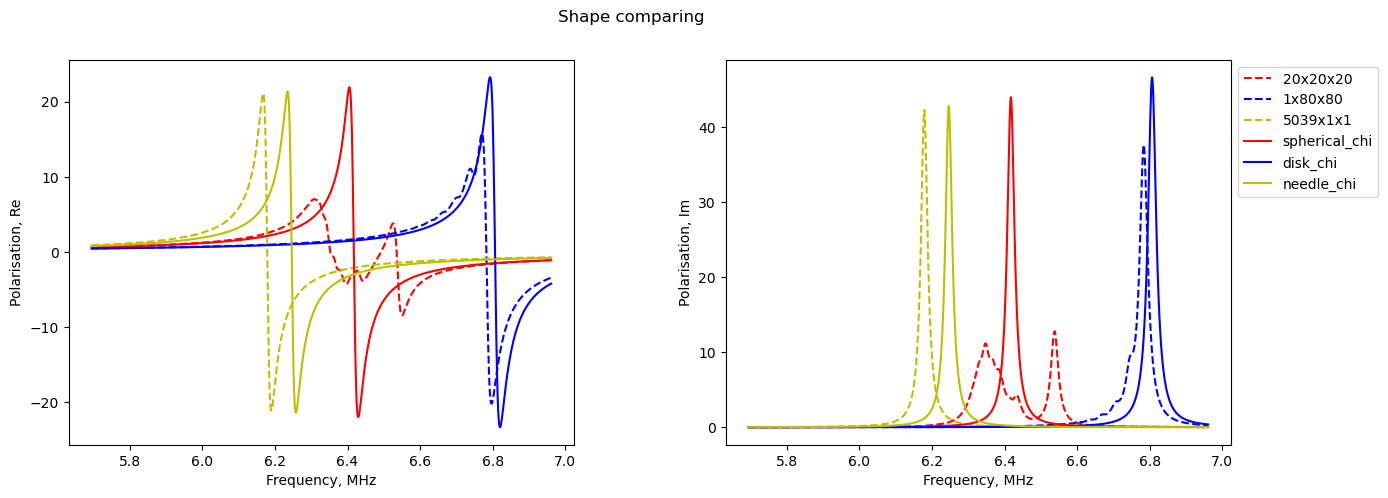

In [19]:
# Compare exact structures
import json
import numpy as np
import matplotlib.pyplot as plt
from Verifying_MRI.Parameters_MRI import Params
from Straight_Method import effective_mu, spherical_chi, disk_chi, needle_chi

omega_0 = 1/np.sqrt(Params['L'] * Params['C'])


# Compare big, average and small cube structures

plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.3, hspace=0.3)   
for n, linestyle in zip([1, 1.5, 2], ['-', '--', '-.']):
    shape = f'{int(n * 10) }x{int(n * 10) }x{int(n * 10)}'
    Nz, Ny, Nx = int(n*10+1), int(n*10+1), int(n*10+1)
    Volume =  (Nx-1) * (Ny-1) * (Nz-1)
    Number = Nx * (Ny-1) * (Nz-1) + (Nx-1) * Ny * (Nz-1) + (Nx-1) * (Ny-1) * Nz
    alpha = Volume/Number
    with open(f"Data/Form_Data/izotropic/Evolving/BorderData-zyx-{shape}", "r") as f:
        Data = json.load(f)
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealZPolarisation"]) 
    ImagPolarisation = np.array(Data["ImagZPolarisation"]) 
    plt.subplot(121)
    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{shape}', linestyle = linestyle, color = 'r')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{shape}', linestyle = linestyle, color = 'r')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")

plt.suptitle('Cube size comparing')
plt.subplot(121)
ylim = plt.ylim()
#plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.subplot(122)
ylim = plt.ylim()
#plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend()
plt.show()

# Compare big, average and small flat structures

plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.3, hspace=0.3)  
for n, linestyle in zip(['1x80x80', '1x52x52', '1x29x29'], ['-', '--', '-.']):
    shape = n
    # Nz, Ny, Nx = n+1, 32*n, 32*n
    # Volume =  (Nx-1) * (Ny-1) * (Nz-1)
    # Number = Nx * (Ny-1) * (Nz-1) + (Nx-1) * Ny * (Nz-1) + (Nx-1) * (Ny-1) * Nz
    # alpha = Volume/Number
    with open(f"Data/Form_Data/izotropic/Evolving/BorderData-zyx-{shape}", "r") as f:
        Data = json.load(f)
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealZPolarisation"]) 
    ImagPolarisation = np.array(Data["ImagZPolarisation"]) 
    plt.subplot(121)
    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{shape}', linestyle = linestyle, color = 'b')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{shape}', linestyle = linestyle, color = 'b')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")

plt.suptitle('Flat size comparing')
plt.subplot(121)
ylim = plt.ylim()
plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.subplot(122)
ylim = plt.ylim()
plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend()
plt.show()

# Compare big, average and small needle structures

plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.3, hspace=0.3)  
for n, linestyle in zip(['659x1x1', '2159x1x1','5039x1x1'], ['-', '--', '-.']):
    shape = n
    # Nz, Ny, Nx = n*1000+1, n+1, n+1
    # Volume =  (Nx-1) * (Ny-1) * (Nz-1)
    # Number = Nx * (Ny-1) * (Nz-1) + (Nx-1) * Ny * (Nz-1) + (Nx-1) * (Ny-1) * Nz
    # alpha = Volume/Number
    with open(f"Data/Form_Data/izotropic/Evolving/BorderData-zyx-{shape}", "r") as f:
        Data = json.load(f)
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealZPolarisation"]) 
    ImagPolarisation = np.array(Data["ImagZPolarisation"])
    plt.subplot(121)
    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{shape}', linestyle = linestyle, color = 'y')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{shape}', linestyle = linestyle, color = 'y')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")

plt.suptitle('Needle size comparing')
plt.subplot(121)
ylim = plt.ylim()
#plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.subplot(122)
ylim = plt.ylim()
#plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend()
plt.show()

# Compare disk, needle and spherical structures
plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.3, hspace=0.3)  
for shape, color in zip(['20x20x20', '1x80x80', '5039x1x1'], ['r', 'b', 'y']):
    Nz, Ny, Nx = [int(i) for i in shape.split('x')]
    # Volume =  (Nx-1) * (Ny-1) * (Nz-1)
    # Number = Nx * (Ny-1) * (Nz-1) + (Nx-1) * Ny * (Nz-1) + (Nx-1) * (Ny-1) * Nz
    # alpha = Volume/Number
    with open(f"Data/Form_Data/izotropic/Evolving/BorderData-zyx-{shape}", "r") as f:
        Data = json.load(f)
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealZPolarisation"]) 
    ImagPolarisation = np.array(Data["ImagZPolarisation"]) 
    plt.subplot(121)
    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{shape}', color = color, linestyle = '--')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{shape}', color = color, linestyle = '--')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")

for theory, color in zip([spherical_chi, disk_chi, needle_chi], ['r', 'b', 'y']):
    MU = effective_mu(Params)(Omega)
    CHI = theory(MU)
    plt.subplot(121)
    plt.plot(Omega/2/np.pi/10**6, CHI.real, label = theory.__name__, color = color)
    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, CHI.imag, label = theory.__name__, color = color)

plt.suptitle('Shape comparing')
plt.subplot(121)
ylim = plt.ylim()
#plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.subplot(122)
ylim = plt.ylim()
#plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


### Dependency of resounance frequency from size

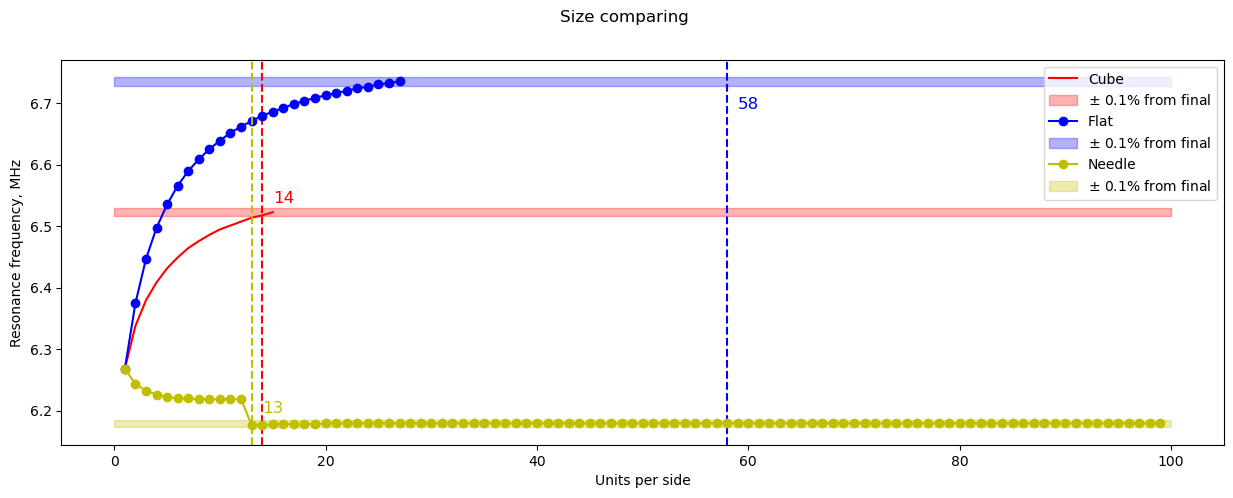

In [2]:
# Compare exact structures
import json
import numpy as np
import matplotlib.pyplot as plt

# Compare big, average and small cube structures

plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

N = np.arange(1, 16)
Resounance_Frequence = []  
for n in N:
    Params['N'], Params['shape'] = to3D(n, n, n, 'zyx')
    data = open_model('DATA', Params, Currents = 'False', Polarization = 'True')
    Resounance_Frequence.append(data['Omega'][np.argmax(data['Polarization'][:, 0].imag)])

Resounance_Frequence = np.array(Resounance_Frequence)
Limit_Frequence = Resounance_Frequence[-1]
delta = 0.001 * Limit_Frequence
first_after = N[np.where(np.abs(Resounance_Frequence - Limit_Frequence) < delta)[0][0]]


plt.suptitle('Size comparing')
plt.plot(N, Resounance_Frequence/1e6/2/np.pi,
          label = 'Cube', color = 'red')
plt.fill_between([0, 100], (Limit_Frequence - delta)/1e6/2/np.pi, (Limit_Frequence + delta)/1e6/2/np.pi,
                 color = 'red', alpha = 0.3,
                 label = '$\pm$ 0.1% from final')
plt.axvline(x=first_after, color = 'red', linestyle = '--')
plt.text(first_after+1, Resounance_Frequence[np.where(np.abs(Resounance_Frequence - Limit_Frequence) < delta)[0][0]]/1e6/2/np.pi+0.02, f'{first_after}', fontsize=12, color='r')

# Compare big, average and small flat structures

Resounance_Frequence = []  

N = np.arange(1, 28)
for n in N:
    Params['N'], Params['shape'] = to3D(1, n, n, 'zyx')
    data = open_model('DATA', Params, Currents = 'False', Polarization = 'True')
    Resounance_Frequence.append(data['Omega'][np.argmax(data['Polarization'][:, 0].imag)])

Resounance_Frequence = np.array(Resounance_Frequence)
Limit_Frequence = Resounance_Frequence[-1]
delta = 0.001 * Limit_Frequence
first_after = N[np.where(np.abs(Resounance_Frequence - Limit_Frequence) < delta)[0][0]]

plt.plot(N, Resounance_Frequence/1e6/2/np.pi,
          label = 'Flat', color = 'blue', marker = 'o')
plt.fill_between([0, 100], (Limit_Frequence - delta)/1e6/2/np.pi, (Limit_Frequence + delta)/1e6/2/np.pi,
                 color = 'blue', alpha = 0.3,
                 label = '$\pm$ 0.1% from final')
plt.axvline(x=58, color = 'blue', linestyle = '--')
plt.text(58+1, Resounance_Frequence[np.where(np.abs(Resounance_Frequence - Limit_Frequence) < delta)[0][0]]/1e6/2/np.pi-0.04, f'{58}', fontsize=12, color='blue')

# Compare big, average and small needle structures

Resounance_Frequence = []  
N = np.arange(1, 100)

for n in N:
    Params['N'], Params['shape'] = to3D(n, 1, 1, 'zyx')
    data = open_model('DATA', Params, Currents = 'False', Polarization = 'True')
    Resounance_Frequence.append(data['Omega'][np.argmax(data['Polarization'][:, 0].imag)])

Resounance_Frequence = np.array(Resounance_Frequence)
Limit_Frequence = Resounance_Frequence[-1]
delta = 0.001 * Limit_Frequence
first_after = N[np.where(np.abs(Resounance_Frequence - Limit_Frequence) < delta)[0][0]]

plt.plot(N, Resounance_Frequence/1e6/2/np.pi,
          label = 'Needle', color = 'y', marker=  'o')
plt.fill_between([0, 100], (Limit_Frequence - delta)/1e6/2/np.pi, (Limit_Frequence + delta)/1e6/2/np.pi,
                 color = 'y', alpha = 0.3,
                 label = '$\pm$ 0.1% from final')
plt.axvline(x=first_after, color = 'y', linestyle = '--')
plt.text(first_after+1, Resounance_Frequence[np.where(np.abs(Resounance_Frequence - Limit_Frequence) < delta)[0][0]]/1e6/2/np.pi+0.02, f'{first_after}', fontsize=12, color='y')

plt.xlabel('Units per side')
plt.ylabel('Resonance frequency, MHz')
plt.legend()
plt.show()


In [ ]:
# Theory plotting
for theory in [spherical_chi, disk_chi, needle_chi]:
    MU = effective_mu(Params)(Omega)
    CHI = theory(MU)
    plt.subplot(121)
    plt.plot(Omega/2/np.pi/10**6, CHI.real, label = theory.__name__)
    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, CHI.imag, label = theory.__name__)

plt.subplot(121)
ylim = plt.ylim()
plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.subplot(122)
ylim = plt.ylim()
plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()



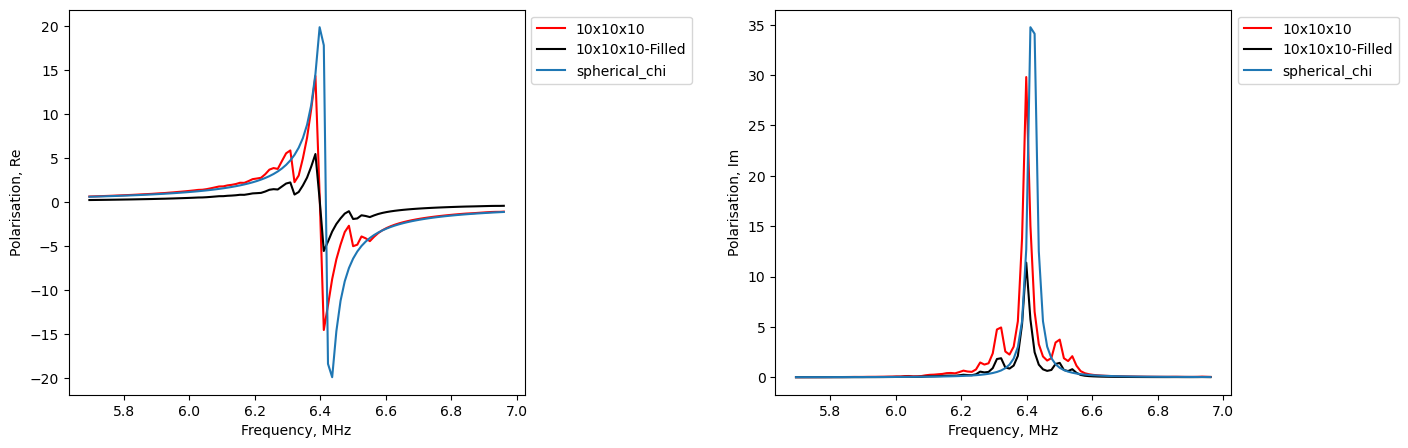

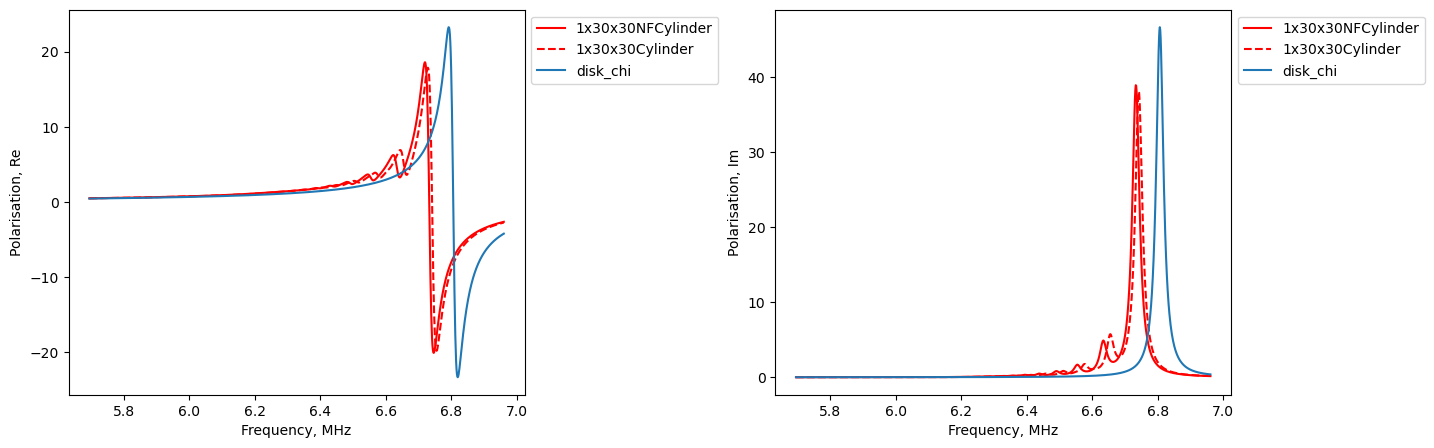

In [30]:
# Compare sphere with and without filling


import json
import numpy as np
import matplotlib.pyplot as plt
from Verifying_MRI.Parameters_MRI import Params
from Straight_Method import effective_mu, spherical_chi, disk_chi, needle_chi
Params['R'] = 0.002
Params['L'] = 13.459 * 10 ** -9
Params['C'] = 470 * 10 ** -12*100
omega_0 = 1/np.sqrt(Params['L'] * Params['C'])


# Compare big, average and small sphere structures

plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.55, hspace=0.55)   
for n, linestyle in zip([1], ['-']):
    shape = f'{n * 10}x{n * 10}x{n * 10}'
    Nz, Ny, Nx = n*10+1, n*10+1, n*10+1
    Volume =  (Nx-1) * (Ny-1) * (Nz-1)
    Number = Nx * (Ny-1) * (Nz-1) + (Nx-1) * Ny * (Nz-1) + (Nx-1) * (Ny-1) * Nz
    alpha = Volume/Number
    with open(f"Data/Form_Data/izotropic/Evolving/StraightData-NFSphere-zyx-{shape}", "r") as f:
        Data = json.load(f)
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealZPolarisation"])
    ImagPolarisation = np.array(Data["ImagZPolarisation"])
    plt.subplot(121)
    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{shape}', linestyle = linestyle, color = 'r')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{shape}', linestyle = linestyle, color = 'r')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")

# Compare big, average and small cube structures

for n, linestyle in zip([1], ['-']):
    shape = f'{n * 10}x{n * 10}x{n * 10}'
    Nz, Ny, Nx = n*10, n*10, n*10

    with open(f"Data/Form_Data/izotropic/Evolving/StraightData-Sphere-zyx-{shape}", "r") as f:
        Data = json.load(f)
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealZPolarisation"])
    ImagPolarisation = np.array(Data["ImagZPolarisation"])
    plt.subplot(121)
    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{shape}-Filled', linestyle = linestyle, color = 'black')
    plt.legend()
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{shape}-Filled', linestyle = linestyle, color = 'black')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")

for theory in [spherical_chi]:
    MU = effective_mu(Params)(Omega)
    CHI = theory(MU)
    plt.subplot(121)
    plt.plot(Omega/2/np.pi/10**6, CHI.real, label = theory.__name__)
    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, CHI.imag, label = theory.__name__)

plt.subplot(121)
ylim = plt.ylim()
#plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.subplot(122)
ylim = plt.ylim()
#plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Compare big, average and small cylinder structures

plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.55, hspace=0.55)   
for name, linestyle in zip(['NFCylinder', 'Cylinder'], ['-', '--']):
    shape = '1x30x30'
    with open(f"Data/Form_Data/izotropic/Evolving/StraightData-{name}-zyx-{shape}", "r") as f:
        Data = json.load(f)
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealZPolarisation"])
    ImagPolarisation = np.array(Data["ImagZPolarisation"])
    plt.subplot(121)
    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{shape}{name}', linestyle = linestyle, color = 'r')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{shape}{name}', linestyle = linestyle, color = 'r')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")

# for n, linestyle in zip(['1x29x29'], ['-.']):
#     shape = n
#     # Nz, Ny, Nx = n+1, 32*n, 32*n
#     # Volume =  (Nx-1) * (Ny-1) * (Nz-1)
#     # Number = Nx * (Ny-1) * (Nz-1) + (Nx-1) * Ny * (Nz-1) + (Nx-1) * (Ny-1) * Nz
#     # alpha = Volume/Number
#     with open(f"Data/Form_Data/izotropic/Evolving/BorderData-zyx-{shape}", "r") as f:
#         Data = json.load(f)
#     Omega = np.array(Data["Omega"])
#     RealPolarisation = np.array(Data["RealZPolarisation"]) 
#     ImagPolarisation = np.array(Data["ImagZPolarisation"]) 
#     plt.subplot(121)
#     plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{shape} square', linestyle = linestyle, color = 'b')
#     plt.xlabel("Frequency, MHz")
#     plt.ylabel("Polarisation, Re")

#     plt.subplot(122)
#     plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{shape} sq', linestyle = linestyle, color = 'b')
#     plt.xlabel("Frequency, MHz")
#     plt.ylabel("Polarisation, Im")

for theory in [disk_chi]:
    MU = effective_mu(Params)(Omega)
    CHI = theory(MU)
    plt.subplot(121)
    plt.plot(Omega/2/np.pi/10**6, CHI.real, label = theory.__name__)
    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, CHI.imag, label = theory.__name__)

plt.subplot(121)
ylim = plt.ylim()
#plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.subplot(122)
ylim = plt.ylim()
#plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Drawing GIFs for parameters evolution

 98%|█████████▊| 98/100 [00:05<00:00, 17.41it/s]

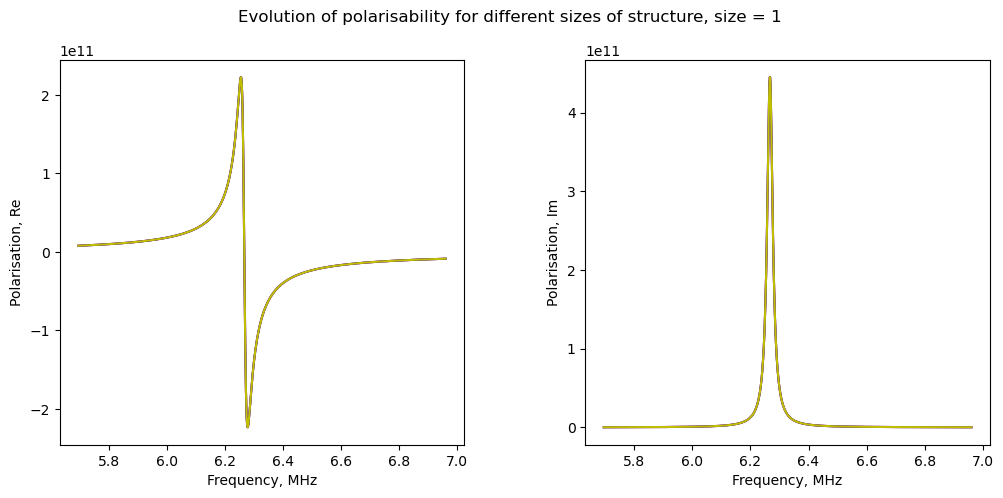

 98%|█████████▊| 98/100 [00:20<00:00, 17.41it/s]

In [3]:
# Compare evolution of polarisability for real and imaginary parts.
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from tqdm import tqdm
import matplotlib.animation as anime

fig, ax = plt.subplots()
# Numbers of plots in x and y axes

def plot_GIF(i):
    # Clearing figure and set figsize
    plt.clf()
    fig.set_size_inches(12, 5)

    # Set title and space between plots

    plt.subplots_adjust(wspace=0.3, hspace=0.3)  
    plt.suptitle(f"Evolution of polarisability for different sizes of structure, size = {i}")
    
    # Plotting cube
    Params['N'], Params['shape'] = to3D(i, i, i, 'zyx')
    shape_cube = Params['shape']
    name = f'{Params["Packing"]}_NoGrad_{Params["shape"]}_{Params["Orientations"]}_{Params["Solver_type"]}'
    if os.path.exists(f"./DATA/{name}"):
        data = open_model('DATA', Params, Currents = 'False', Polarization = 'True')
        Omega = data['Omega']
        RealPolarisation = data['Polarization'][:, 0].real
        ImagPolarisation = data['Polarization'][:, 0].imag

        plt.subplot(121)
        plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{shape_cube}', color = 'r')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Re")

        plt.subplot(122)
        plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{shape_cube}', color = 'r')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Im")

    # Plotting flat
    Params['N'], Params['shape'] = to3D(1, i, i, 'zyx')
    shape_flat = Params['shape']
    name = f'{Params["Packing"]}_NoGrad_{Params["shape"]}_{Params["Orientations"]}_{Params["Solver_type"]}'
    if os.path.exists(f"./DATA/{name}"):
        data = open_model('DATA', Params, Currents = 'False', Polarization = 'True')
        Omega = data['Omega']
        RealPolarisation = data['Polarization'][:, 0].real
        ImagPolarisation = data['Polarization'][:, 0].imag

        plt.subplot(121)
        plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{shape_flat}', color = 'b')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Re")

        plt.subplot(122)
        plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{shape_flat}', color = 'b')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Im")
    
    # Plotting needle
    Params['N'], Params['shape'] = to3D(i, 1, 1, 'zyx')
    shape_needle = Params['shape']
    name = f'{Params["Packing"]}_NoGrad_{Params["shape"]}_{Params["Orientations"]}_{Params["Solver_type"]}'
    if os.path.exists(f"./DATA/{name}"):
        data = open_model('DATA', Params, Currents = 'False', Polarization = 'True')
        Omega = data['Omega']
        RealPolarisation = data['Polarization'][:, 0].real
        ImagPolarisation = data['Polarization'][:, 0].imag

        plt.subplot(121)
        plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{shape_needle}', color = 'y')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Re")

        plt.subplot(122)
        plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{shape_needle}', color = 'y')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Im")

        
# Make and save animation object
ani = anime.FuncAnimation(fig, plot_GIF,
                          frames = tqdm(range(1, 101)),
                          interval = 50
                          )

ani.save(f'Size_increasing.gif', writer='pillow', fps=5, dpi=100)

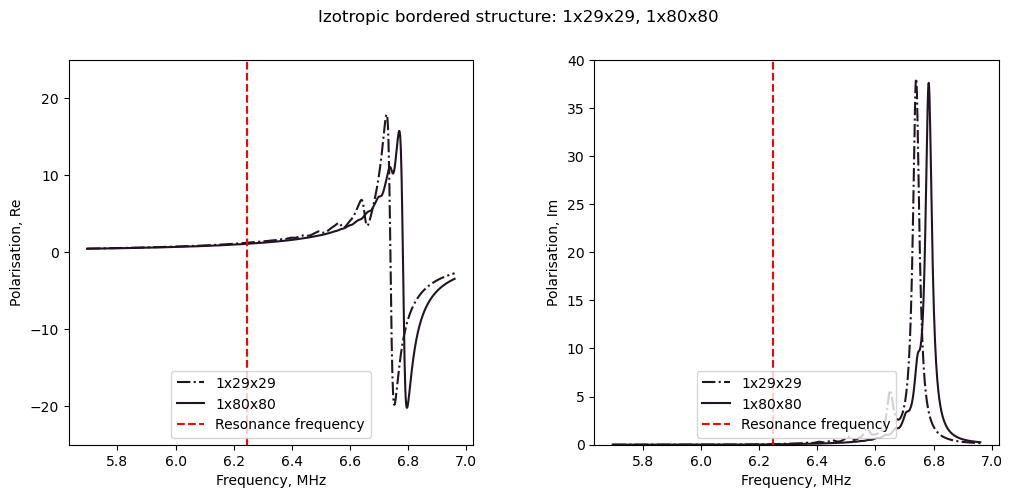

In [57]:
# Compare evolution of polarisability for real and imaginary parts.
import matplotlib.pyplot as plt
import numpy as np
import json
from Verifying_MRI.Parameters_MRI import Dz, Dy, Dx, Radius, omega_0 as Omega_0, Params
import json
import matplotlib.animation as anime

Params['R'] = 0.002
Params['L'] = 13.459 * 10 ** -9
Params['C'] = 470 * 10 ** -12*100
omega_0 = Omega_0/10
mu_0 = 4 * np.pi * 10**-7

N_big = 21*20*20 * 3
N_small = 11*10*10 * 3

shapes = []
for Nz_big in range(1, 19):
    Nz_small = int(np.ceil(Nz_big/2))
    
    n_other_big = int(round((Nz_big + np.sqrt(Nz_big**2 + N_big*(3*Nz_big+1)))/(3*Nz_big+1)))
    n_other_small = int(round((Nz_small + np.sqrt(Nz_small**2 + N_small*(3*Nz_small+1)))/(3*Nz_small+1)))

    shapes.append((f'{Nz_big}x{n_other_big}x{n_other_big}', f'{Nz_small}x{n_other_small}x{n_other_small}') )

shapes.append((f'19x21x21', '10x10x10'))
shapes.append((f'20x20x20', '10x10x10'))

for n_other_big in range(19, 0, -1):
    n_other_small = int(np.ceil(n_other_big/2))
    
    Nz_big = (N_big - n_other_big**2) // (3*n_other_big**2  + 2*n_other_big)
    Nz_small = (N_small - n_other_small**2) // (3*n_other_small**2  + 2*n_other_small)
    shapes.append((f'{Nz_big}x{n_other_big}x{n_other_big}', f'{Nz_small}x{n_other_small}x{n_other_small}') )

fig, ax = plt.subplots()
# Numbers of plots in x and y axes

def plot_GIF(shape):
    # Clearing figure and set figsize
    plt.clf()
    fig.set_size_inches(12, 5)

    # Set title and space between plots
    Nz_big, Ny_big, Nx_big = [int(i) for i in shape[0].split('x')]
    Nz_small, Ny_small, Nx_small = [int(i) for i in shape[1].split('x')]

    plt.subplots_adjust(wspace=0.3, hspace=0.3)  
    plt.suptitle(f"Izotropic bordered structure: {Nz_small}x{Ny_small}x{Nx_small}, {Nz_big}x{Ny_big}x{Nx_big}")
    color = f'#22{hex((min(Nz_small+1, Ny_small+1)) * 10)[2:]}22'


    with open(f"Data/Form_Data/izotropic/Evolving/BorderData-zyx-{Nz_small}x{Ny_small}x{Nx_small}", "r") as f:
        Data = json.load(f)

    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealZPolarisation"])
    ImagPolarisation = np.array(Data["ImagZPolarisation"])

    plt.subplot(121)
    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{Nz_small}x{Ny_small}x{Nx_small}', color = color, linestyle = '-.')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{Nz_small}x{Ny_small}x{Nx_small}', color = color, linestyle = '-.')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")

    with open(f"Data/Form_Data/izotropic/Evolving/BorderData-zyx-{Nz_big}x{Ny_big}x{Nx_big}", "r") as f:
        Data = json.load(f)

    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealZPolarisation"])
    ImagPolarisation = np.array(Data["ImagZPolarisation"])
    plt.subplot(121)
    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{Nz_big}x{Ny_big}x{Nx_big}', color = color)
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{Nz_big}x{Ny_big}x{Nx_big}', color = color)
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")

    plt.subplot(121)
    plt.ylim(-25, 25)
    plt.axvline(omega_0/2/np.pi/10**6, color="red", linestyle="--", label='Resonance frequency')
    plt.legend(loc = 'lower center')
    plt.subplot(122)
    plt.ylim(0, 40)
    plt.axvline(omega_0/2/np.pi/10**6, color="red", linestyle="--", label='Resonance frequency')
    plt.legend(loc = 'lower center')

        
# Make and save animation object
ani = anime.FuncAnimation(fig, plot_GIF,
                          frames = shapes,
                          interval = 50
                          )

ani.save(f'BorderReIm-Evolution.gif', writer='pillow', fps=10, dpi=100)

In [38]:
# Draw polarisation for substructures for extreme cases
import matplotlib.pyplot as plt
import numpy as np
import json
from Verifying_MRI.Parameters_MRI import Dz, Dy, Dx, Radius, omega_0, Params
import json
from PIL import Image

Params['R'] = 0.01
Params['L'] = 13.459 * 10 ** -9
Params['C'] = 470 * 10 ** -12*100
omega_0 = 1/np.sqrt(Params['L'] * Params['C'])
mu_0 = 4 * np.pi * 10**-7
dims = 'z'
H_0z = 1
# Define fucntions for calculating polarisation for substructures
def Chi(I_w, shape, slice_deep, pos):
    start = 0
    for Type in shape:
        if Type != pos:
            start += np.prod([shape[Type][j] for j in shape[Type]])
        else:
            break
    end = start + np.prod([shape[pos][j] for j in shape[pos]])
    I_3d = np.array(I_w[:, start:end]).reshape([I_w.shape[0]] + [shape[pos][j] for j in shape[pos]])

    P_0z = np.pi * Radius ** 2 /Dz/Dy/Dx/H_0z
    # find start and end of substructure avoiding empty or 1 element substructures
    nz, ny, nx = [shape[pos][j] for j in shape[pos]]
    nz_min, ny_min, nx_min = 2 - (nz-(pos =='z'))%2 + (pos == 'z'), 2 - (ny-(pos =='y'))%2 + (pos == 'y'), 2 - (nx-(pos =='x'))%2 + (pos == 'x')

    start_nz = min((nz - nz_min)//2, slice_deep)
    start_ny = min((ny - ny_min)//2, slice_deep)
    start_nx = min((nx - nx_min)//2, slice_deep)

    end_nz = max(nz - (nz - nz_min)//2, nz - slice_deep)
    end_ny = max(ny - (ny - ny_min)//2, ny - slice_deep)
    end_nx = max(nx - (nx - nx_min)//2, nx - slice_deep)
    number = (end_nz - start_nz) * (end_ny - start_ny) * (end_nx - start_nx)
    nz, ny, nx = end_nz - start_nz, end_ny - start_ny, end_nx - start_nx
    return np.sum(I_3d[:, start_nz:end_nz, start_ny:end_ny, start_nx:end_nx], axis = (1, 2, 3))* P_0z/number, nz, ny, nx

images = []

Nz, Ny, Nx = 659, 1, 1
max_slice = max(Nz, Ny, Nx)//2
# # Calculate polarisation for substructures

dims = 'zyx'
Polarisations_fft = {}
NZ_fft, NY_fft, NX_fft = {}, {}, {}
slice_or = 'z'
with open(f"Data/Form_Data/izotropic/Evolving/BorderCurrents-{dims}-{Nz}x{Ny}x{Nx}", "r") as f:
    Data = json.load(f)
    Currents_fft = np.array(Data["RealCurrents"]) + 1j * np.array(Data["ImagCurrents"])
    shape_fft = Data['Params']['N']
    
    Omega_fft = np.array(Data["Omega"])

    for slice_deep in range(0, max_slice):
        polarisation, Nz, Ny, Nx = Chi(Currents_fft, shape_fft, slice_deep, slice_or)
        NZ_fft[slice_deep], NY_fft[slice_deep], NX_fft[slice_deep] = Nz, Ny+1, Nx+1
        Polarisations_fft[slice_deep] = polarisation


    central_pos = 'z'
    cental_z, central_y, cenral_x = 659//2, 0, 0
    start = 0
    for Type in shape_fft:
        if Type != central_pos:
            start += np.prod([shape_fft[Type][j] for j in shape_fft[Type]])
        else:
            break
    end = start + np.prod([shape_fft[central_pos][j] for j in shape_fft[central_pos]])

    central_polarisation_fft =  np.pi * Radius ** 2 /Dz/Dy/Dx/H_0z * Currents_fft[:, start:end].reshape((len(Omega_fft), shape_fft['z']['nz'], shape_fft['z']['ny'], shape_fft['z']['nx']))[:, cental_z, central_y, cenral_x]

# Polarisations_straight = {}
# NZ_straight, NY_straight, NX_straight = {}, {}, {}
# Nz, Ny, Nx = 10, 10, 10
# slice_or = 'z'
# with open (f'Data/Form_Data/izotropic/Cube/S-Currents-{dims}-{Nz}x{Ny}x{Nx}', 'r') as f:
#     Data = json.load(f)
#     Currents_straight = np.array(Data["RealCurrents"]) + 1j * np.array(Data["ImagCurrents"])
#     Omega_straight = np.array(Data["Omega"])
#     shape_straight = {
#         'z': {'nz': 11, 'ny':10, 'nx': 10},
#         'y': {'nz': 10, 'ny': 11, 'nx': 10},
#         'x': {'nz': 10, 'ny': 10, 'nx': 11}
#         }

#     for slice_deep in range(0, (max(Nz, Ny, Nx))//2):
#         polarisation, Nz, Ny, Nx = Chi(Currents_straight, shape_straight, slice_deep, slice_or)

#         NZ_straight[slice_deep], NY_straight[slice_deep], NX_straight[slice_deep] = Nz, Ny+1, Nx+1
#         Polarisations_straight[slice_deep] = polarisation

#     central_pos = 'z'
#     cental_z, central_y, cenral_x = 5, 5, 5
#     end_z = 1100

#     central_polarisation_straight = P_0z = np.pi * Radius ** 2 /Dz/Dy/Dx/H_0z * Currents_straight[:, :end_z].reshape((1000, 11, 10, 10))[:, cental_z, central_y, cenral_x]


    

        
    
       


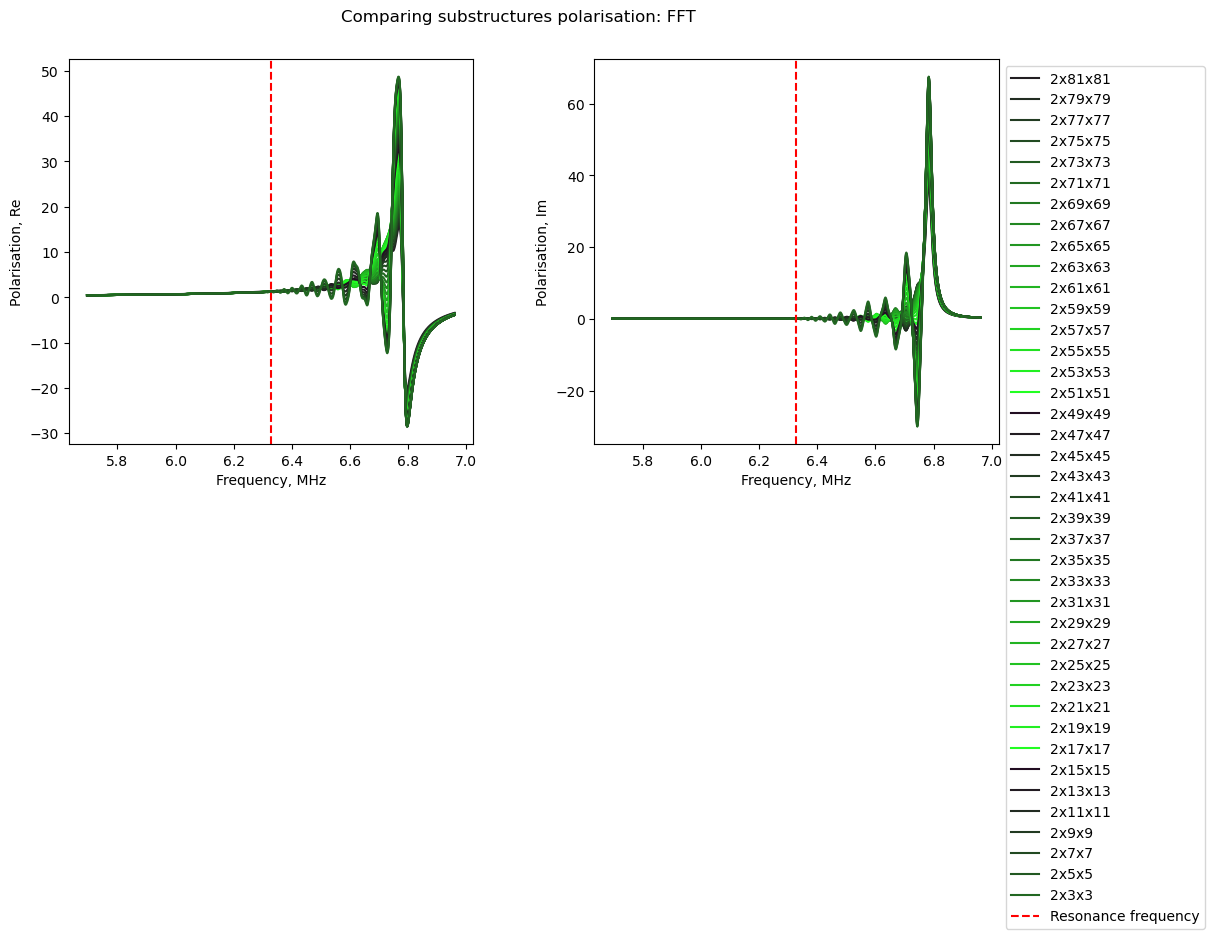

In [63]:

plt.figure(figsize=(12, 5))

plt.suptitle(f"Comparing substructures polarisation: FFT")
for slice_deep in range(0, 40):
    polarisation_fft = Polarisations_fft[slice_deep]
    #polarisation_straight = Polarisations_straight[slice_deep]
    Nz_fft, Ny_fft, Nx_fft = NZ_fft[slice_deep], NY_fft[slice_deep], NX_fft[slice_deep]
    #Nz_straight, Ny_straight, Nx_straight = NZ_straight[slice_deep], NY_straight[slice_deep], NX_straight[slice_deep]

    plt.subplot(121)

    #plt.plot(Omega_straight/2/np.pi/10**6, np.real(polarisation_straight), label = f'{Nz_straight}x{Ny_straight}x{Nx_straight}', color = f'#22{hex((slice_deep+1) * 20)[-2:]}22')
    plt.plot(Omega_fft/2/np.pi/10**6, np.real(polarisation_fft), label = f'{Nz_fft}x{Ny_fft}x{Nx_fft}', color = f'#22{hex((slice_deep+2) * 15)[-2:]}22')
    
    plt.subplot(122)

    #plt.plot(Omega_straight/2/np.pi/10**6, np.imag(polarisation_straight), label = f'{Nz_straight}x{Ny_straight}x{Nx_straight}', color = f'#22{hex((slice_deep+1) * 20)[-2:]}22')
    plt.plot(Omega_fft/2/np.pi/10**6, np.imag(polarisation_fft), label = f'{Nz_fft}x{Ny_fft}x{Nx_fft}', color = f'#22{hex((slice_deep+2) * 15)[-2:]}22')

plt.subplot(121)
plt.xlabel("Frequency, MHz")
plt.ylabel("Polarisation, Re")
plt.axvline(omega_0/2/np.pi/10**6, color="red", linestyle="--", label='Resonance frequency')
plt.subplot(122)
plt.xlabel("Frequency, MHz")
plt.ylabel("Polarisation, Im")
plt.axvline(omega_0/2/np.pi/10**6, color="red", linestyle="--", label='Resonance frequency')
plt.legend(bbox_to_anchor=(1, 1))
plt.subplots_adjust(wspace=0.3, hspace=0.0) 
plt.show()



6.246530910011538


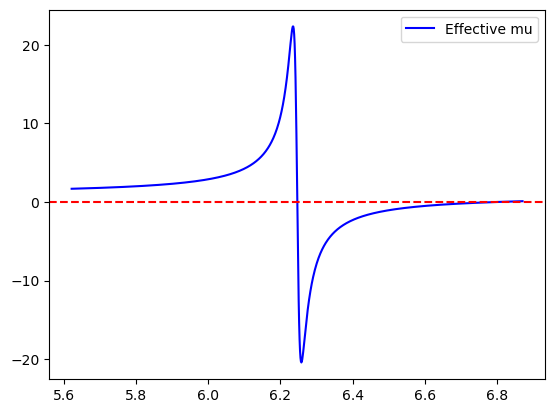

In [14]:
from Straight_Method import effective_mu
from Verifying_MRI.Parameters_MRI import omega_0 as omega_r, Params
import numpy as np
import matplotlib.pyplot as plt
Params['R'] = 0.002
Params['L'] = 13.459 * 10 ** -9
Params['C'] = 470 * 10 ** -12*100
omega_0 = omega_r/10

# L = 13.459 * 10 ** -9                   # Self-inductance
# C = 470 * 10 ** -12                     # Capacitance
# R = 0.0465/10                              # Resistance

# Params['R'] = R
# Params['L'] = L
# Params['C'] = C
#omega_0 = 1/np.sqrt(Params['L'] * Params['C'])

Omega_fft = np.linspace(0.9 * omega_0, 1.1*omega_0, 1000)
mu_0 = 4 * np.pi * 10 ** (-7)
r = Params['Radius']
R = Params['R']
C = Params['C']
L = Params['L']
a = Params['Dz']
sigma = -0.06
k_1 = mu_0 * r * sigma
k_2 = mu_0 * np.pi ** 2 * r ** 4 /(a ** 3)
def effective_mu(Params, frequency = False):
    mu_0 = 4 * np.pi * 10 ** (-7)
    r = Params['Radius']
    R = Params['R']
    C = Params['C']
    L = Params['L']
    a = Params['Dz']
    sigma = -0.06

    Z = lambda Omega : R + 1j * Omega * L + 1/(1j * Omega * C) + 1j * Omega * mu_0 * r * sigma
    Const =  lambda Omega: - 1j * Omega * mu_0 * np.pi ** 2 * r ** 4 /(a ** 3)
    if frequency:
        return lambda w: (Z(w) + 2/3 * Const(w))/(Z(w) - 1/3 * Const(w)) 
    return lambda w: (Z(w) + 2/3 * Const(w))/(Z(w) - 1/3 * Const(w))

dw = 0.000001 * omega_0
omega_start = 0.9 * omega_0
while np.real(effective_mu(Params)(omega_start)) > 0:
    omega_start += dw
print(omega_start/np.pi/2e6)
#plt.plot(Omega_fft/np.pi/1e6/2, np.imag(effective_mu(Params)(Omega_fft)), label = 'Effective mu', color = 'blue')
plt.plot(Omega_fft/np.pi/1e6/2, np.real(effective_mu(Params)(Omega_fft)), label = 'Effective mu', color = 'blue')
#plt.plot(Omega_fft/np.pi/1e6/2, np.imag(1/z(Omega_fft)), label = 'Imag z')

a = L ** 2 + k_1 ** 2 - 2/9 * k_2 ** 2
b = R ** 2
c = 1/(C ** 2)
D  = b ** 2 - 4 * a * c

plt.legend()
plt.axhline(0, color = 'red', linestyle = '--')


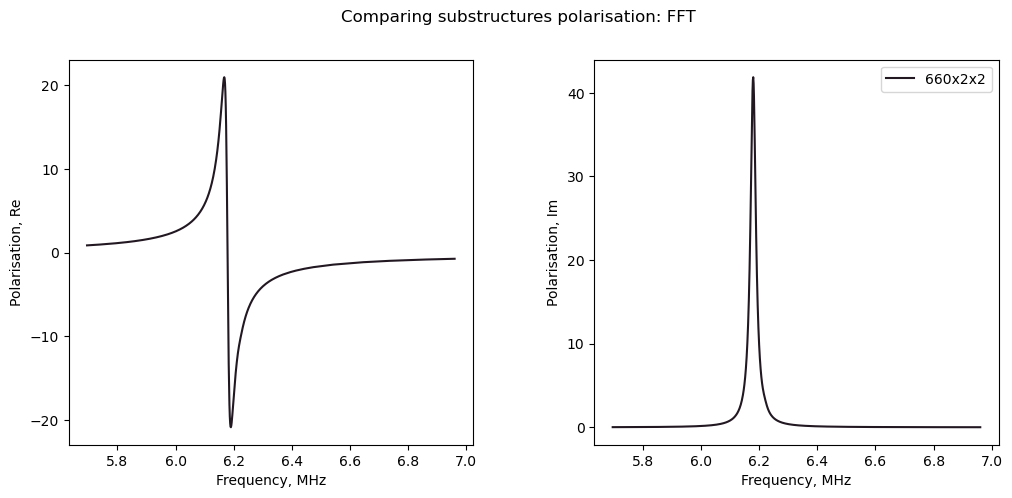

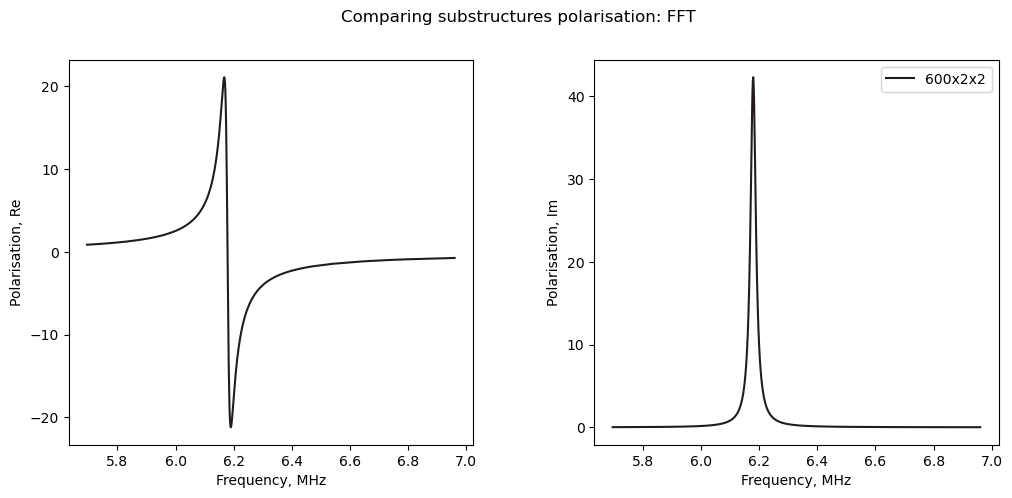

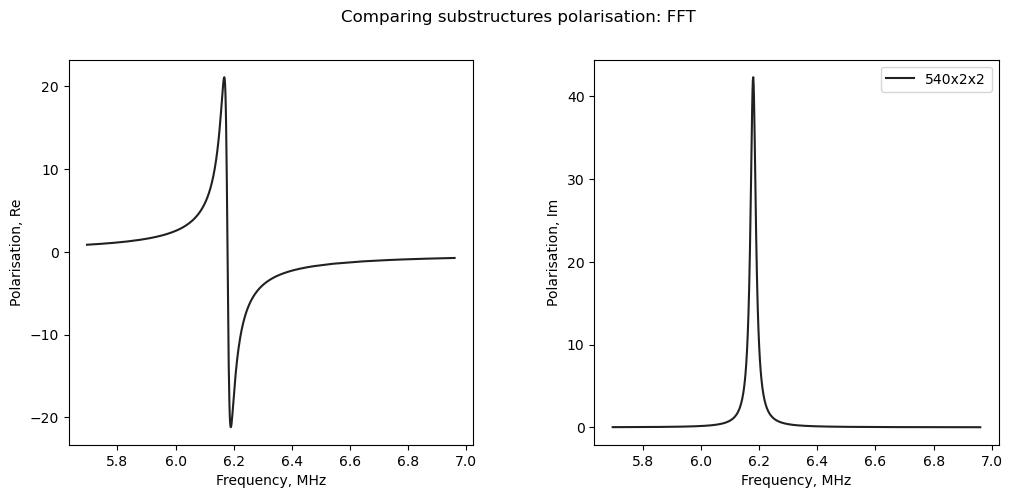

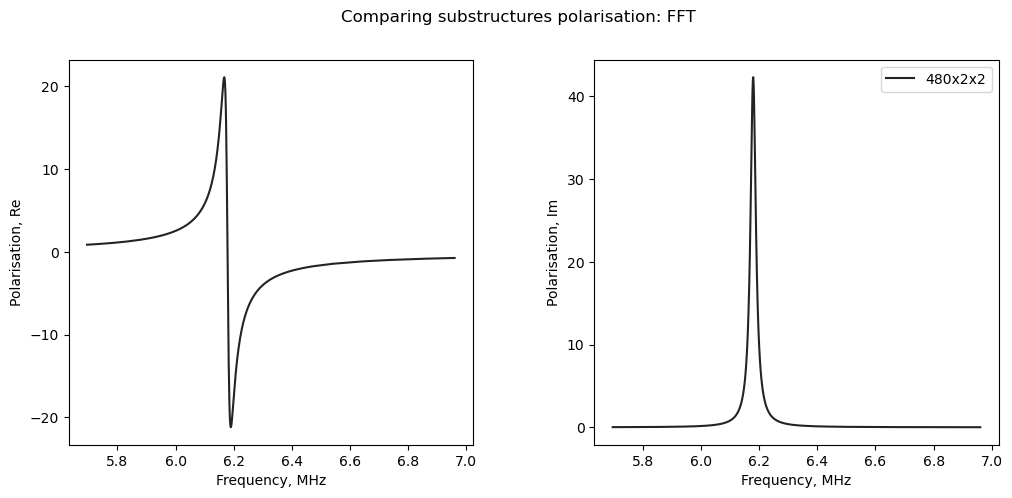

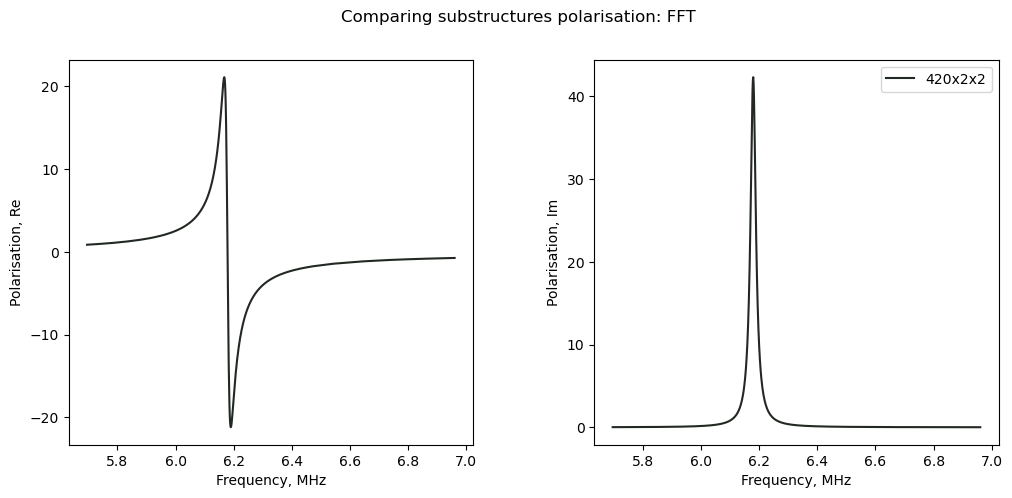

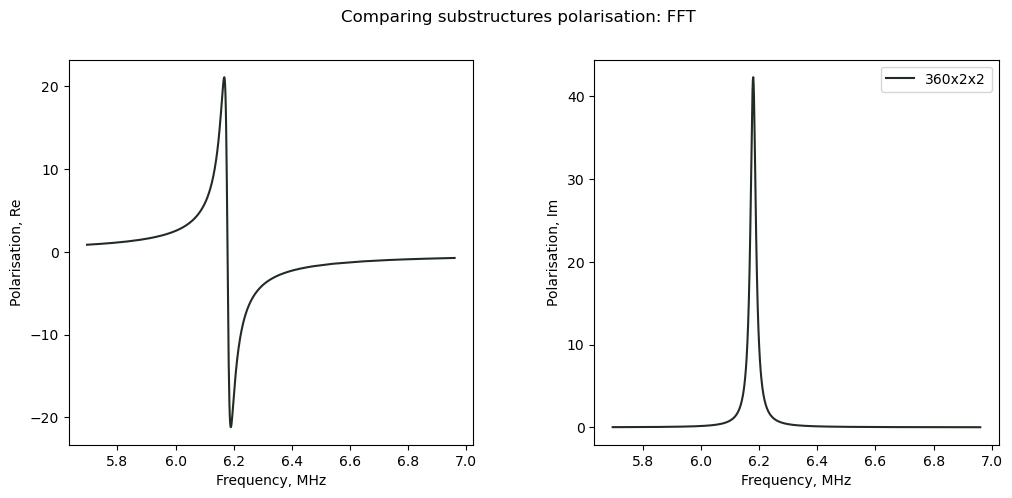

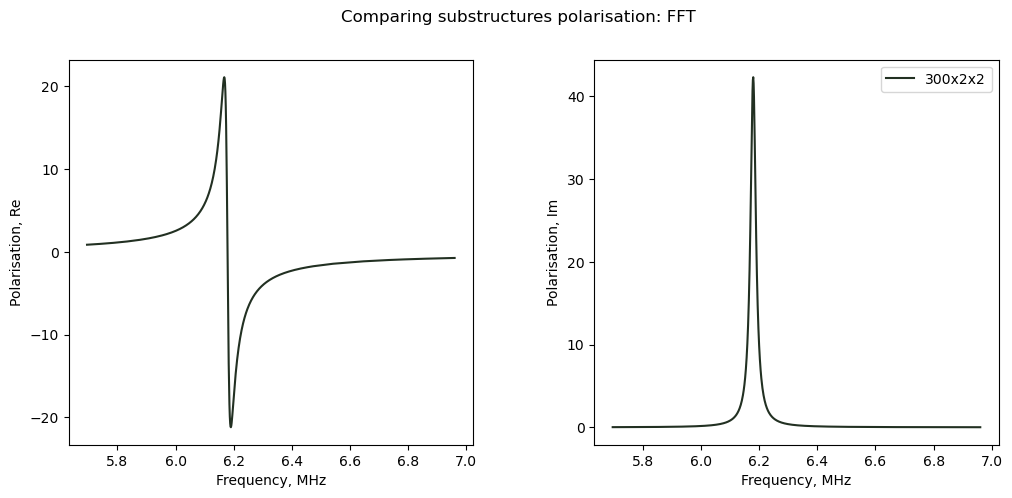

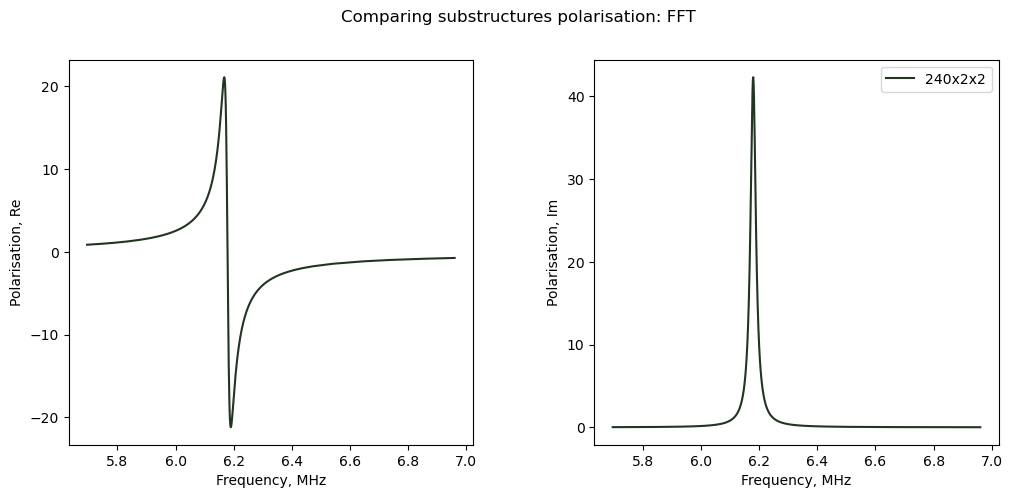

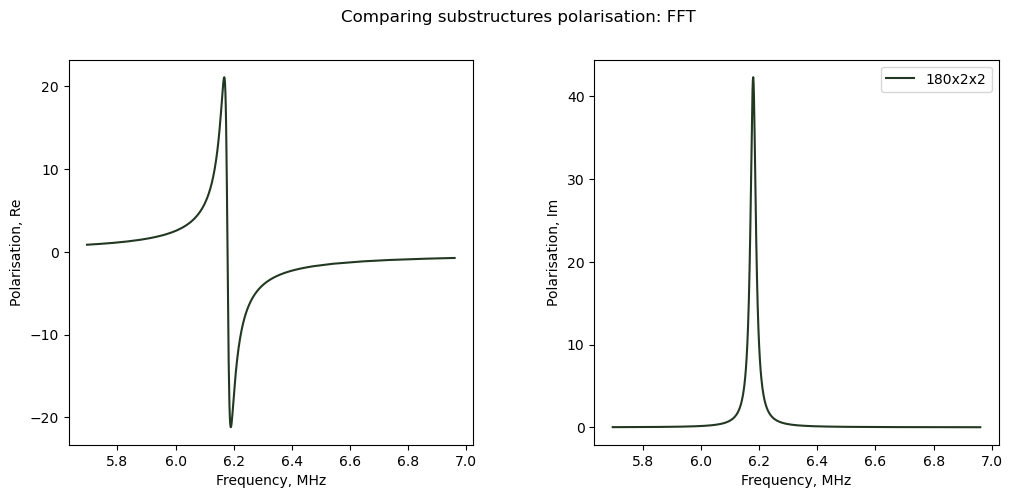

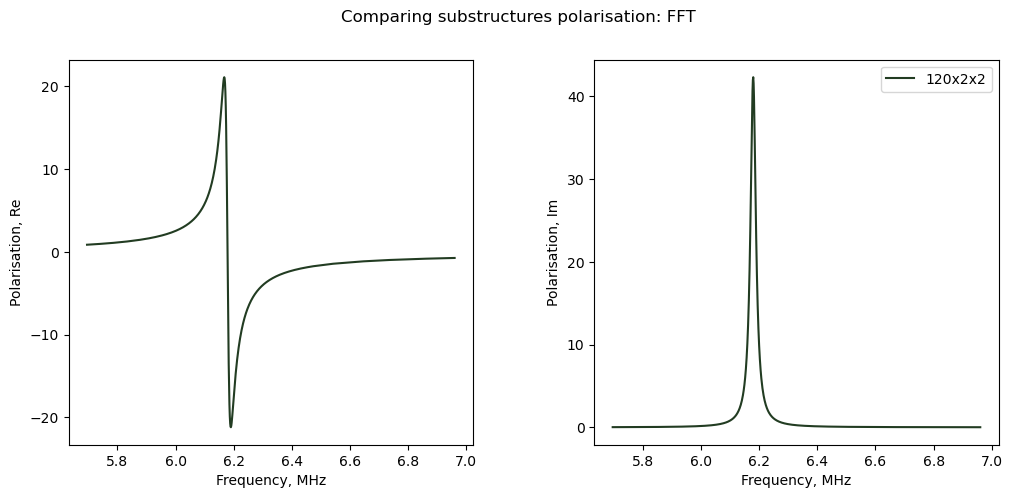

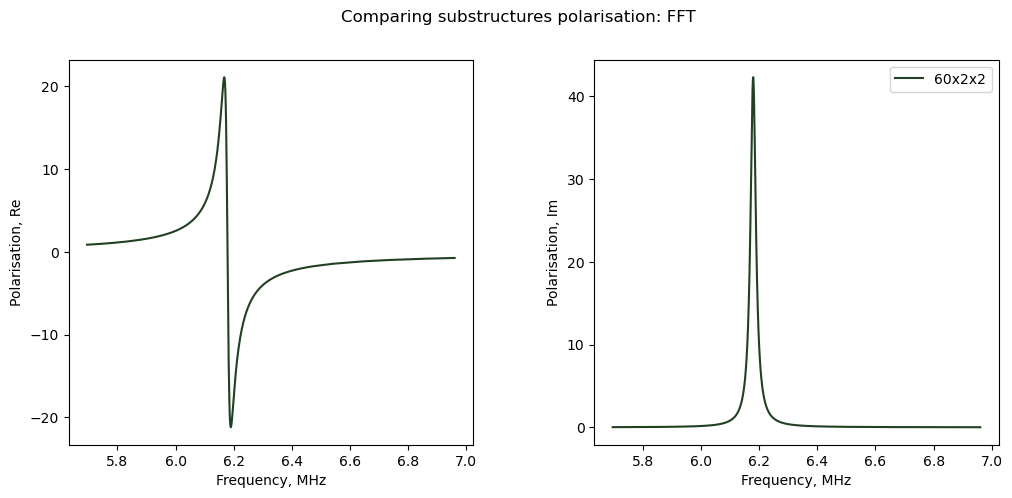

In [39]:
from Verifying_MRI.Parameters_MRI import omega_0
omega_0 = omega_0/10
images = []

for slice_deep in range(0, max_slice, 30):
    plt.figure(figsize=(12, 5))
    plt.suptitle(f"Comparing substructures polarisation: FFT")
    polarisation_fft = Polarisations_fft[slice_deep]
    #polarisation_straight = Polarisations_straight[slice_deep]
    Nz_fft, Ny_fft, Nx_fft = NZ_fft[slice_deep], NY_fft[slice_deep], NX_fft[slice_deep]
    #Nz_straight, Ny_straight, Nx_straight = NZ_straight[slice_deep], NY_straight[slice_deep], NX_straight[slice_deep]

    plt.subplot(121)

    #plt.plot(Omega_fft/2/np.pi/1e6, np.real(central_polarisation_fft), label = 'border-ring', color = 'red')
    #plt.plot(Omega_straight/2/np.pi/1e6, np.real(central_polarisation_straight), label = 'central-ring-straight', color = 'red')
    #plt.plot(Omega_straight/2/np.pi/10**6, np.real(polarisation_straight), label = f'{Nz_straight}x{Ny_straight}x{Nx_straight}-straight', color = f'#22{hex((slice_deep+1) * 20)[-2:]}22')
    plt.plot(Omega_fft/2/np.pi/10**6, np.real(polarisation_fft), label = f'{Nz_fft}x{Ny_fft}x{Nx_fft}-fft', color = f'#22{hex((slice_deep//30+6) * 4)[-2:]}22')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")
    #plt.axvline(omega_0/2/np.pi/10**6, color="red", linestyle="--", label='Resonance frequency')

    plt.subplot(122)

    #plt.plot(Omega_fft/2/np.pi/10**6, np.imag(central_polarisation_fft), label = 'border-ring', color = 'red')
    #plt.plot(Omega_straight/2/np.pi/10**6, np.imag(central_polarisation_straight), label = 'central-ring-straight', color = 'red')
    #plt.plot(Omega_straight/2/np.pi/10**6, np.imag(polarisation_straight), label = f'{Nz_straight}x{Ny_straight}x{Nx_straight}', color = f'#22{hex((slice_deep+1) * 20)[-2:]}22')
    plt.plot(Omega_fft/2/np.pi/10**6, np.imag(polarisation_fft), label = f'{Nz_fft}x{Ny_fft}x{Nx_fft}', color = f'#22{hex((slice_deep//30+6) * 4)[-2:]}22')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")
    #plt.axvline(omega_0/2/np.pi/10**6, color="red", linestyle="--", label='Resonance frequency')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.subplot(122)

    plt.subplots_adjust(wspace=0.3, hspace=0.0) 

    plt.savefig(f"Plots/Form/CubeSlicingGIF.jpg")
    img = Image.open('Plots/Form/CubeSlicingGIF.jpg')
    img.show()
    images.append(img)
    

images[0].save('Plots/Form/NeedleSubstructures.gif', save_all=True,
                 append_images=images[1:],
                 duration=500,
                 loop=0)

# Anizotopic anilyse

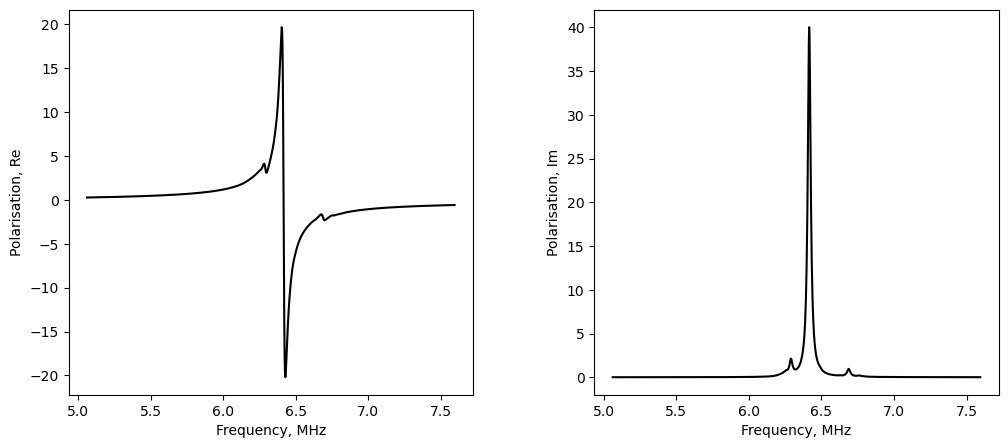

In [5]:
# Plot anizotropoc structure
import json
import numpy as np
import matplotlib.pyplot as plt
from Verifying_MRI.Parameters_MRI import Params
from Straight_Method import effective_mu, spherical_chi, disk_chi, needle_chi
Params['R'] = 0.002
Params['L'] = 13.459 * 10 ** -9
Params['C'] = 470 * 10 ** -12*100
omega_0 = 1/np.sqrt(Params['L'] * Params['C'])



for pos in Grad:
    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.suptitle(f'Compare anizotropic gradient: {pos}')
    for grad in Grad[pos]:
        with open(f"Data/Grad_Data/anizotropic/Cube/Data-z-20x20x20-{max(grad)}", "r") as f:
            Data = json.load(f)
        Omega = np.array(Data["Omega"])
        RealPolarisation = np.array(Data["RealZPolarisation"]) 
        ImagPolarisation = np.array(Data["ImagZPolarisation"]) 
        plt.subplot(121)
        plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{grad}', linestyle = '-', label = max(grad))
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Re")
    
        plt.subplot(122)
        plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{grad}', linestyle = '-')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Im")

# Compare maximum gradient in each direction
plt.figure(figsize=(12, 5))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.suptitle(f'Compare anizotropic gradient: max')
for pos in Grad:
    with open(f"Data/Grad_Data/anizotropic/Cube/{pos}-grad/Data-z-20x20x20-0.3", "r") as f:
        Data = json.load(f)
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealZPolarisation"]) 
    ImagPolarisation = np.array(Data["ImagZPolarisation"]) 
    plt.subplot(121)
    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{grad}', linestyle = '-', label = max(grad))
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{grad}', linestyle = '-')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")


# Drawing Currents distribution

In [29]:
# Making GIF for polarisation for different orientations
import json
import numpy as np
import matplotlib.pyplot as plt


# Get Data for plotting
Data = {}
shapes = ['10x10x10', '58x4x4', '1x80x80']
dims = 'zyx'
for shape in shapes:    
    with open(f"Data/Form_Data/izotropic/Evolving/BorderCurrents-{dims}-{shape}", "r") as f:
        Data[shape] = json.load(f)

Nz, Ny, Nx = 11, 11, 11
with open (f'Data/Form_Data/izotropic/Cube/S-Currents-{dims}-{Nz}x{Ny}x{Nx}', 'r') as f:
    Data_straight = json.load(f)

Data = Data_fft.copy()
Data_errors['RealCurrents'] = abs(np.array(Data['10x10x10']['RealCurrents'])- np.array(Data_straight['RealCurrents'])))
Data_errors['ImagCurrents'] = abs(np.array(Data['10x10x10']['ImagCurrents'])- np.array(Data_straight['ImagCurrents'])))


In [ ]:
# Calculate polarisation for slices
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as anime
from tqdm import tqdm

# Drawing GIFs

def SaveDistribution(Data, rtype, slice_deep, slice_or, name):
    Currents_4D = np.array(Data["RealCurrents"], dtype = complex) + 1j * np.array(Data["ImagCurrents"], dtype= complex)
    Omega = np.array(Data["Omega"])

    Params = Data['Params']
    Dz, Dy, Dx = Params['Dz'], Params['Dy'], Params['Dx']
    N = Params['N']
    H_0z = 1

    Radius = Params['Radius']
    start = 0
    for ring_type in N:
        if ring_type != rtype:
            start += np.prod([N[ring_type][j] for j in N[ring_type]])
        else:
            break
    end = start + np.prod([N[rtype][j] for j in N[rtype]])

    rslice = [slice(slice_deep * (slice_or =='z'), (slice_deep+1)*(slice_or=='z') + N[rtype]['nz'] * (slice_or != 'z'), 1),
      slice(slice_deep * (slice_or =='y'), (slice_deep+1)*(slice_or=='y') + N[rtype]['ny'] * (slice_or != 'y'), 1),
      slice(slice_deep * (slice_or =='x'), (slice_deep+1)*(slice_or=='x') + N[rtype]['nx'] * (slice_or != 'x'), 1)]

    Currents2D = np.real(np.squeeze(Currents_4D[:,start:end].reshape([len(Omega)]+ [N[rtype][j] for j in N[rtype]])[:, *rslice]))*np.pi * Radius ** 2 /Dz/Dy/Dx/H_0z

    # Calculate extremums for each slice
    MaxCurrents = Currents2D.max()
    MinCurrents = Currents2D.min()
    MaxDeltaCurrents = MaxCurrents - MinCurrents

    fig, ax = plt.subplots()
    
    
    n_1, n_2 = tuple([j for j in N[rtype].keys() if j != f'n{slice_or}'])
        
    X, Y = list(range(N[rtype][n_1])), list(range(N[rtype][n_2]))

    def plot_GIF(i):
        plt.clf()

        fig.set_size_inches((12, 10))
        ax.set_aspect(len(Y)/len(X))

        Currents = Currents2D[i]
        omega = Omega[i]
        
        Lines = plt.contour(X, Y, Currents.T, 6, colors = 'black')

        Imax, Imin = Currents.max(), Currents.min()
        DeltaCurrents = np.real(Imax) - np.real(Imin)

        amplitude = DeltaCurrents/MaxDeltaCurrents
        middlepos = (Imin-MinCurrents)/(MaxDeltaCurrents - DeltaCurrents)
        ticksnumber = round(amplitude * 10) + 1
        ticks = list(map(lambda x: round(np.real(x), 2), np.linspace(Imax, Imin, ticksnumber)))

        plt.xlabel(n_1, fontsize = 15)
        plt.ylabel(n_2, fontsize = 15)

        plt.contourf(X, Y, Currents.T, 100, cmap=plt.cm.hot)
        plt.clabel(Lines, inline=1, fontsize=15)
        plt.colorbar(label = r'$\chi$', fraction = 0.03, pad = 0.05, 
                          shrink = 10, aspect = amplitude/0.03, anchor = (0, middlepos),
                          ticks = ticks)
        plt.title(f"{slice_or} slice on {slice_deep} layer for {rtype}-ring: $f =${round(omega/2/np.pi/10 ** 6, 3)}, MHz", fontsize = 15)

    ani = anime.FuncAnimation(fig, plot_GIF,
                              frames = 1,#tqdm(list(range(len(Omega)))),
                              interval = 50
                              )

    ani.save(f'{name}.gif', writer='imagemagick', fps=24)

for rtype in ('z', 'y', 'x'):
    for slice_or in ('z', 'y', 'x'):
            for slice_deep in (0, 4, 9):
                SaveDistribution(Data_fft, rtype, slice_deep, slice_or, f'Plots/Current_distribution/Form/Cube-11x11x11-{rtype}ring-{slice_or}slice-{slice_deep}-fft')
                SaveDistribution(Data_straight, rtype, slice_deep, slice_or, f'Plots/Form/Slicing-Cube-11x11x11-{rtype}-ring-{slice_or}slice-{slice_deep}-straight')

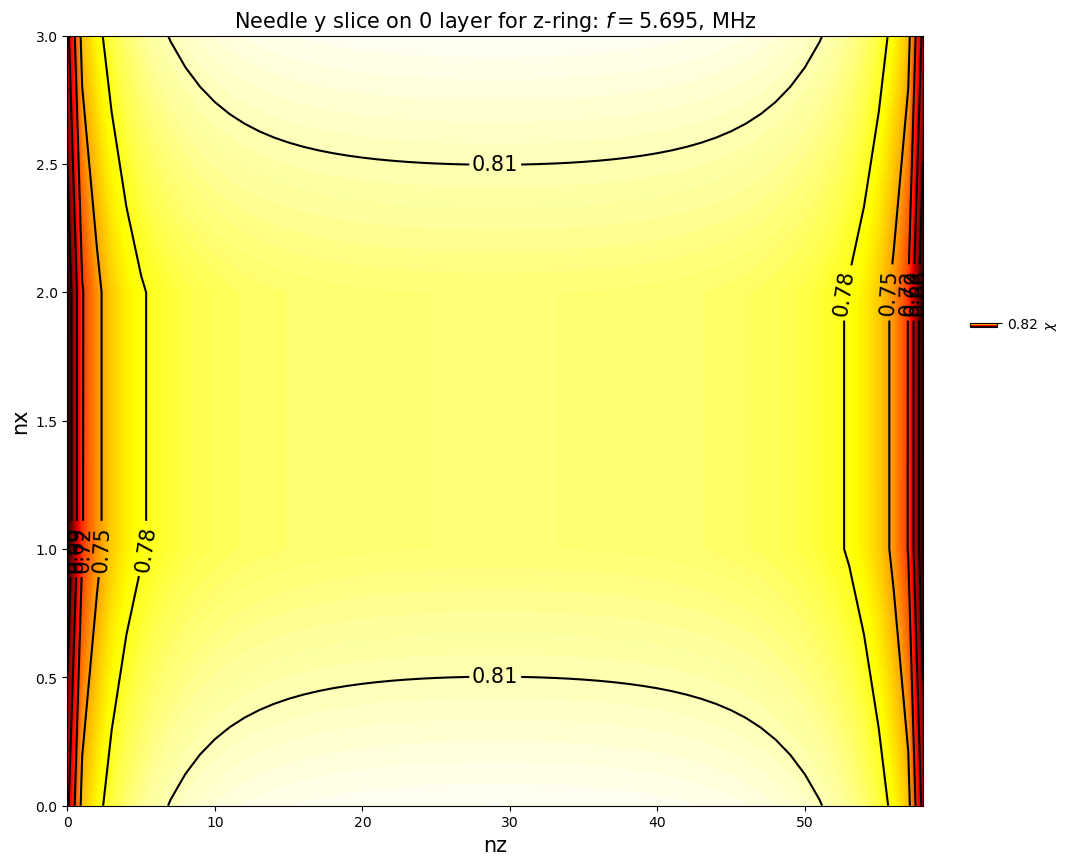

In [32]:
# Calculate and compare polarisation for different structures

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as anime
from tqdm import tqdm

# Drawing GIFs

''' 
- Datas_sets is a dictionary with keys as names of datasets and values as datasets
- rtypes is a list of ring types
- slice_ors is a list of slice orientations
- slice_deeps is a dictionary with keys as tuples (name, rtype, slice_or) and values as lists of slice deeps,
number of slice deeps should be the same for each id
- name is a name of the GIF 
'''
def SaveDistribution(Data_sets, rtypes, slice_ors, slice_deeps, Name):
    
    # Get Data for plotting
    Currents2D = {}
    Omega = {}
    MaxCurrents = {}
    MinCurrents = {}
    MaxDeltaCurrents = {}
    n_1, n_2 = {}, {}
    X, Y = {}, {}

    grid_num = 0
    for name in Data_sets:
        Data = Data_sets[name]
        Omega[name] = np.array(Data["Omega"])
        Currents_4D = np.array(Data["RealCurrents"], dtype = complex) + 1j * np.array(Data["ImagCurrents"], dtype= complex)

        Params = Data['Params']

        Dz, Dy, Dx = Params['Dz'], Params['Dy'], Params['Dx']
        Radius = Params['Radius']
        N = Params['N']
        H_0z = 1

        for rtype in rtypes:
            start = 0
            # Calculate start and end positions for each ring type
            for ring_type in N:
                if ring_type != rtype:
                    start += np.prod([N[ring_type][j] for j in N[ring_type]])
                else:
                    break
            end = start + np.prod([N[rtype][j] for j in N[rtype]])
            
            for slice_or in slice_ors:
                slice_id = (name, rtype, slice_or)
                for slice_deep in slice_deeps[slice_id]:
                    # Calculate position in plotting grid
                    data_pos = 1 + list(Data_sets.keys()).index(name)
                    slice_deep_pos = list(slice_deeps[slice_id]).index(slice_deep) * len(Data_sets)
                    slice_pos = list(slice_ors).index(slice_or) * len(Data_sets) * len(slice_deeps[slice_id])
                    rtype_pos = list(rtypes).index(rtype) * len(Data_sets) * len(slice_ors) * len(slice_deeps[slice_id])

                    grid_num = data_pos + slice_pos + slice_deep_pos + rtype_pos
                    Id = (name, rtype, slice_or, slice_deep, grid_num)
                    
                    # Get current slice for choosen parameters
                    rslice = [slice(slice_deep * (slice_or =='z'), (slice_deep+1)*(slice_or=='z') + N[rtype]['nz'] * (slice_or != 'z'), 1),
                      slice(slice_deep * (slice_or =='y'), (slice_deep+1)*(slice_or=='y') + N[rtype]['ny'] * (slice_or != 'y'), 1),
                      slice(slice_deep * (slice_or =='x'), (slice_deep+1)*(slice_or=='x') + N[rtype]['nx'] * (slice_or != 'x'), 1)]

                    Currents2D[Id] = np.real(np.squeeze(Currents_4D[:,start:end].reshape([len(Omega[name])]+ [N[rtype][j] for j in N[rtype]])[:, *rslice]))*np.pi * Radius ** 2 /Dz/Dy/Dx/H_0z

                    # Calculate extremums for each slice
                    MaxCurrents[Id] = Currents2D[Id].max()
                    MinCurrents[Id] = Currents2D[Id].min()
                    MaxDeltaCurrents[Id] = MaxCurrents[Id] - MinCurrents[Id]

                    n_1[Id], n_2[Id] = tuple([j for j in N[rtype].keys() if j != f'n{slice_or}'])

                    X[Id], Y[Id] = list(range(N[rtype][n_1[Id]])), list(range(N[rtype][n_2[Id]]))
        

    fig, ax = plt.subplots()

    # Numbers of plots in x and y axes

    xn = len(Data_sets) * len(slice_deeps[slice_id])
    yn = len(rtypes) * len(slice_ors) 

    # Figsize
    xsize = xn*12
    ysize = yn*10

    def plot_GIF(i):
        # Clearing figure and set figsize
        plt.clf()
        fig.set_size_inches(xsize, ysize)
        for Id in Currents2D:
            name, rtype, slice_or, slice_deep, grid_num = Id
            
            plt.subplot(yn, xn, grid_num)
            Currents = Currents2D[Id][i]    
            omega = Omega[name][i]

            # Set axes scale and avoid extra long plots

            # Draw same-value lines
            Lines = plt.contour(X[Id], Y[Id], Currents.T, 6, colors = 'black')

            # Calculate max currents to normilze it for spectral max
            Imax, Imin = Currents.max(), Currents.min()
            DeltaCurrents = Imax - Imin
            
            # Calculate length of colorbar
            amplitude = DeltaCurrents/MaxDeltaCurrents[Id]

            if abs((Imin - MinCurrents[Id])/Imin) < 1e-3 and abs((Imax - MaxCurrents[Id])/MaxCurrents[Id]) < 1e-3:
                middlepos = 0
            else:
                middlepos = (Imin-MinCurrents[Id])/(MaxDeltaCurrents[Id] - DeltaCurrents)

            # Calculate number of ticks depended on coloubar length
            ticksnumber = round(amplitude * 10) + 1
            ticks = list(map(lambda x: round(np.real(x), 2), np.linspace(Imax, Imin, ticksnumber)))

            plt.xlabel(n_1[Id], fontsize = 15)
            plt.ylabel(n_2[Id], fontsize = 15)

            # Draw colormap
            plt.contourf(X[Id], Y[Id], Currents.T, 100, cmap=plt.cm.hot)
            plt.clabel(Lines, inline=1, fontsize=15)
            plt.colorbar(label = r'$\chi$', fraction = 0.03, pad = 0.05, 
                              shrink = 10, aspect = amplitude/0.03, anchor = (0, middlepos),
                              ticks = ticks)
            scale = len(Y[Id])/len(X[Id])

            if scale < 1/3:
                ax.set_aspect(1/3)
            elif scale > 3:
                ax.set_aspect(3)
            else:
                ax.set_aspect(scale)
            
            plt.title(f"{name} {slice_or} slice on {slice_deep} layer for {rtype}-ring: $f =${round(omega/2/np.pi/10 ** 6, 3)}, MHz", fontsize = 15)

    # Make and save animation object
    ani = anime.FuncAnimation(fig, plot_GIF,
                              frames = list(range(len(Omega[name]))),
                              interval = 50
                              )

    ani.save(f'{Name}.gif', writer='pillow', fps=24, dpi=80)

Data_sets = {'Needle': Data['10x10x10']}#, 'Straight': Data_straight}
rtypes = ('z')
slice_ors = ('y')
slice_deeps = {}
for name in Data_sets:
    for rtype in rtypes:
        for slice_or in slice_ors:
            slice_deeps[(name, rtype, slice_or)] = [0]
SaveDistribution(Data_sets, rtypes, slice_ors, slice_deeps, f'Plots/Current_distribution/Form/Errors')        

In [24]:
rtype, slice_or = 'x', 'z'
N = {
        'z': {'nz': 11, 'ny':10, 'nx': 10},
        'y': {'nz': 10, 'ny': 11, 'nx': 10},
        'x': {'nz': 10, 'ny': 10, 'nx': 11}
        }
N = {
    'z': { 'nz': 11, 'ny': 10, 'nx': 10},
    'y': { 'nz': 10, 'ny': 11, 'nx': 10},
    'x': { 'nz': 10, 'ny': 10, 'nx': 11}
}
n_1, n_2 = tuple([j for j in N[rtype].keys() if j != f'n{slice_or}'])
print(n_1, n_2)
X, Y = list(range(N[rtype][n_1])), list(range(N[rtype][n_2]))
print(X, Y)
print(X[-1:0:-1])

ny nx
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[9, 8, 7, 6, 5, 4, 3, 2, 1]


MovieWriter imagemagick unavailable; using Pillow instead.


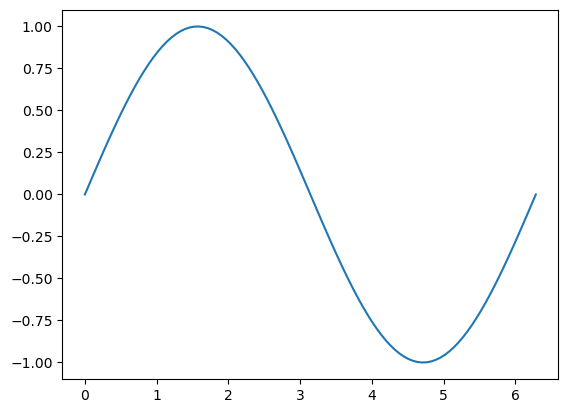

In [4]:

fig, ax = plt.subplots()
def plot_GIF(i):
    ax.clear()
    x = np.linspace(0, 2*np.pi, 100)
    y = np.sin(x + i/10)
    plt.plot(x, y)
ani = anime.FuncAnimation(fig, plot_GIF,
                          frames = len(Omega)//10,
                          interval = 50
                          )
ani.save('Plots/Form/CubeSlicingZ.gif', writer='imagemagick', fps=24)

In [65]:
a = {('a', 'b'): slice(1, 2, 3)}
n_1, n_2 = list(a.keys())[0]
rslice = list(a.values())[0]
print(n_1, n_2 , rslice)
a = np.zeros((5, 5, 5))
rslice = [slice(1, 2, 1), slice(1, 2, 1), slice(1, 2, 1)]
print(a[*rslice].shape)

a b slice(1, 2, 3)
(1, 1, 1)
